## 01 Exploratory data analysis

The goal of this section is to explore the gallstone dataset, identify potential issues, and extract preliminary insights that can guide the later modeling phase. We focus on understanding the structure of the data, the distributions of individual features, relationships between them, and their potential relevance for predicting gallstone status.  


### 1. Data Overview

The dataset consists of clinical, anthropometric, metabolic, and biochemical measurements for several hundred patients. Each patient is labeled with their **gallstone status** (positive/negative), which serves as the target variable for predictive modeling.  


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df_orig = pd.read_csv("data/gallstone_.csv")
missing_values = df_orig.isna().sum().sum()

print(f"The gallstone dataset contains {df_orig.shape[1]-1} features and gallstone diagnose for {df_orig.shape[0]} patients")
print(f"The dataset contains {missing_values} missing values")

The gallstone dataset contains 38 features and gallstone diagnose for 319 patients
The dataset contains 0 missing values


The dataset contains **319** and **38 features** (excluding the target) and does not contain missing values.

To simplify the analysis, we map long or complex column names (containing spaces and units) into shorter, machine-friendly labels. This makes plotting and model development easier while still keeping the original meaning intact.  

In [3]:
col_map = {
    'Gallstone Status': 'gallstone',
    'Age': 'age',
    'Gender': 'gender',
    'Comorbidity': 'comorbidity',
    'Coronary Artery Disease (CAD)': 'cad',
    'Hypothyroidism': 'hypothyroidism',
    'Hyperlipidemia': 'hyperlipidemia',
    'Diabetes Mellitus (DM)': 'diabetes',
    'Height': 'height',
    'Weight': 'weight',
    'Body Mass Index (BMI)': 'bmi',
    'Total Body Water (TBW)': 'tbw',
    'Extracellular Water (ECW)': 'ecw',
    'Intracellular Water (ICW)': 'icw',
    'Extracellular Fluid/Total Body Water (ECF/TBW)': 'ecf_tbw',
    'Total Body Fat Ratio (TBFR) (%)': 'tbfr',
    'Lean Mass (LM) (%)': 'lm',
    'Body Protein Content (Protein) (%)': 'protein',
    'Visceral Fat Rating (VFR)': 'vfr',
    'Bone Mass (BM)': 'bm',
    'Muscle Mass (MM)': 'mm',
    'Obesity (%)': 'obesity',
    'Total Fat Content (TFC)': 'tfc',
    'Visceral Fat Area (VFA)': 'vfa',
    'Visceral Muscle Area (VMA) (Kg)': 'vma',
    'Hepatic Fat Accumulation (HFA)': 'hfa',
    'Glucose': 'glucose',
    'Total Cholesterol (TC)': 'tc',
    'Low Density Lipoprotein (LDL)': 'ldl',
    'High Density Lipoprotein (HDL)': 'hdl',
    'Triglyceride': 'triglyceride',
    'Aspartat Aminotransferaz (AST)': 'ast',
    'Alanin Aminotransferaz (ALT)': 'alt',
    'Alkaline Phosphatase (ALP)': 'alp',
    'Creatinine': 'creatinine',
    'Glomerular Filtration Rate (GFR)': 'gfr',
    'C-Reactive Protein (CRP)': 'crp',
    'Hemoglobin (HGB)': 'hgb',
    'Vitamin D': 'vitamin_d'
}

df = df_orig.rename(columns=col_map)

### 2. Descriptive statistics 

We separate the features into **categorical** and **numerical** groups:  

- **Categorical features** include disease indicators (e.g., diabetes, coronary artery disease, hypothyroidism), gender, and comorbidity. For these, we summarize frequency counts and distributions across gallstone-positive and -negative groups.  
- **Numerical features** include anthropometric measures (height, weight, BMI), body composition (fat, muscle, water), and biochemical markers (glucose, cholesterol, liver/kidney markers). For these, we calculate mean, standard deviation, min/max values, and stratified means by gallstone status.  

This give us a first impression of which variables may be more informative for predicting gallstones.  


In [4]:
disease_features = ["comorbidity", "cad", "hypothyroidism", "hyperlipidemia", "diabetes"]
categorical_cols = ["gallstone", "gender"] + disease_features + ["hfa"]

numerical_cols = [col for col in df.columns if col not in categorical_cols]

cat_summary = pd.DataFrame({col: df[col].value_counts() for col in categorical_cols})
cat_gallstone = df.groupby('gallstone')[categorical_cols[1:]].sum()
num_summary = df[numerical_cols].agg(['mean','std','min','max'])
num_gallstone = df.groupby('gallstone')[numerical_cols].mean()

display(cat_summary.style.format("{:.0f}", na_rep="").set_caption("Descriptive statistics for categorical features"))
display(cat_gallstone.style.format().set_caption("Categorical counts for gallstone status"))
display(num_summary.style.format("{:.2f}").set_caption("Descriptive statistics for numerical features"))
display(num_gallstone.style.format("{:.2f}").set_caption("Numerical mean for gallstone status"))


The statistics above shows that there only 8 patients with hyperlipidemia, 9 patients with hypothyroidism and 12 patients with cad. These features are highly skewed and should be handled carefully during modelling.

### 3. Data Quality

The descriptive statistics revealed two main inconsistencies:  

- **Comorbidity**: This variable is expected be binary (0 = no comorbidity, 1 = comorbidity present). However, a few patients had values of 2 or 3.  
- **Obesity (%)**: The max value is 1954 that does not seem to be plausible for a parameter measured in %.

We inspect these outliers in more details.

In [5]:
display(df[df.obesity>100].style.format().set_caption("Checking obesity: values > 100"))
display(df[df.comorbidity>1].style.format().set_caption("Checking comorbidity: values > 1"))

**Cormorbidity** outliers appear to be data entry errors and can be handled later.  

For **obesity** one patient has an extreme outlier (1954%) and few have values above 100%. Since 1954 is clearly inconsistent with the patient’s BMI and weight, we treat it as a data entry error. Obesity values >100% do not look incompatible with other metrics, let's have a look at the histogram.

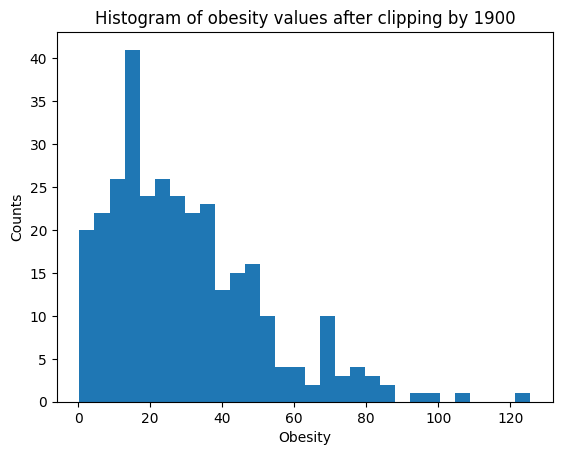

In [6]:
plt.hist(df[df["obesity"]<1900]["obesity"], bins = 30)
plt.xlabel("Obesity")
plt.ylabel("Counts")
plt.title("Histogram of obesity values after clipping by 1900")
plt.show()

While I could not find in literature a method of obesity calculation that outputs more than 100% and obesity values >100% look unusual, they may still represent some alternative measurement method, so we retain them cautiously.  

We should also inspect the gender distribution closer. From the statistics above we see that 157 females 90 have the positive gallstone status but the information about man is not shown due to the encoding.

In [7]:
pd.crosstab(df['gallstone'], df['gender']).style.format().set_caption("Gender vs gallstone")

From the categorical summaries, we observed a **gender imbalance in gallstone prevalence**:  
- Amonf patiance diagnosed with gallstone around **57% are females** and around **43% are males**.  

This discrepancy is clinically plausible (gallstones are more common in women), but it introduces a potential confounder. Data splitting for training/validation might need to preserve gender balance to avoid biased models.  

### 4 Feature Distributions

We already see that some features tend to correlate with the gallstone status like diabetes, obesity, lm, alp, creatinine, vitamin d etc. 
Now we can have a look at feature distributions to visualize data and gain a deeper understanding.
We grouped features into meaningful categories (e.g., anthropometric, metabolic, liver/kidney, biomarkers) and visualized their distributions by gallstone status.  

The outliers mentioned above (obesity = 1954, comorbidity>1) are dropped from now on.

In [8]:
basic_features = ["age", "gender"]
anthropometric_features = ["height", "weight", "bmi"]
water_features = ["tbw", "ecw", "icw", "ecf_tbw"]
fat_features = ["tbfr", "vfr", "tfc", "vfa","hfa", "obesity"]
muscle_features = ["lm", "protein", "mm", "vma", "bm"]
metabolic_features = ["glucose", "tc", "ldl", "hdl", "triglyceride"]
liver_kidney_features = ["ast", "alt", "alp", "creatinine", "gfr"]
biomarker_features = ["crp", "hgb", "vitamin_d"]

feature_groups = {"basic": basic_features, "disease": disease_features, "antropometric": anthropometric_features, 
                  "water":water_features, "fat": fat_features, "muscle": muscle_features, "metabolic": metabolic_features,
                   "liver": liver_kidney_features, "biomarker": biomarker_features}

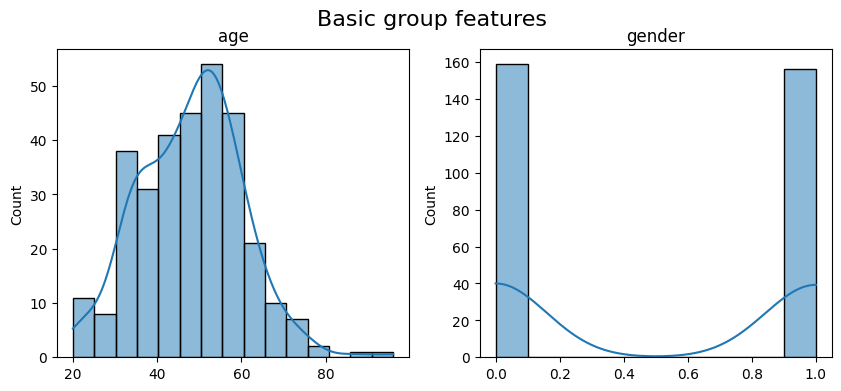

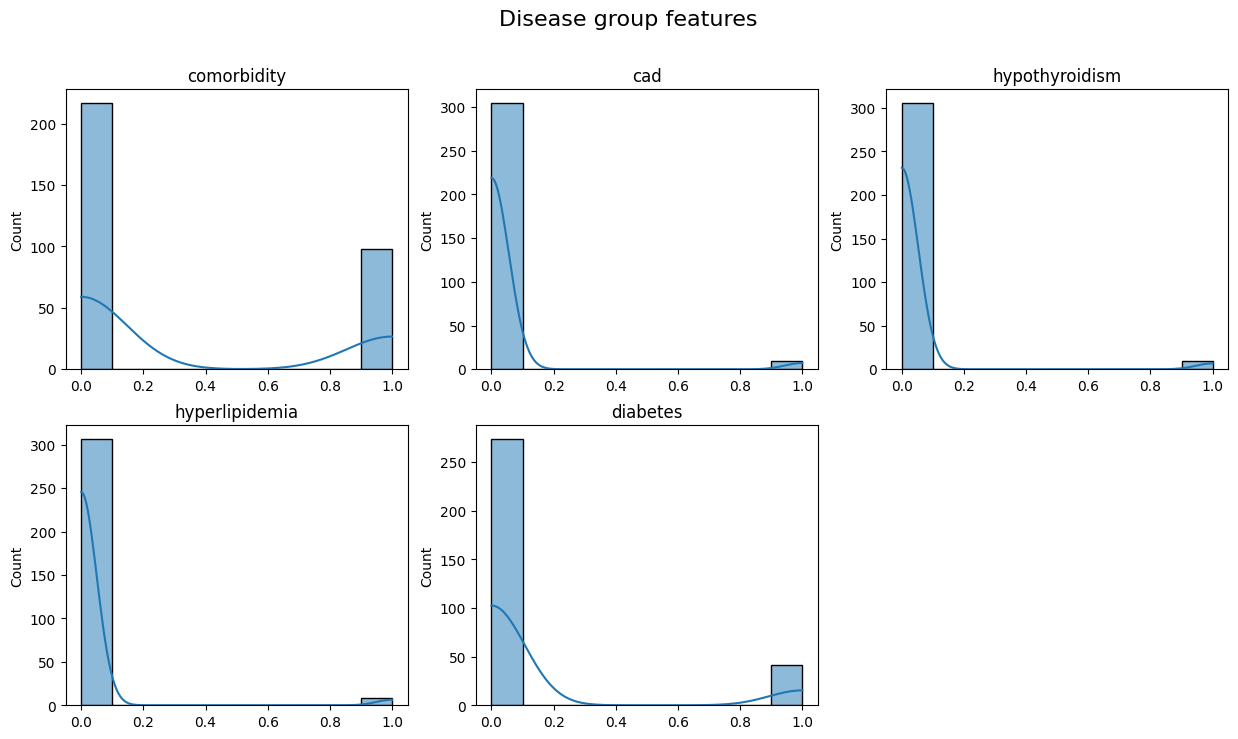

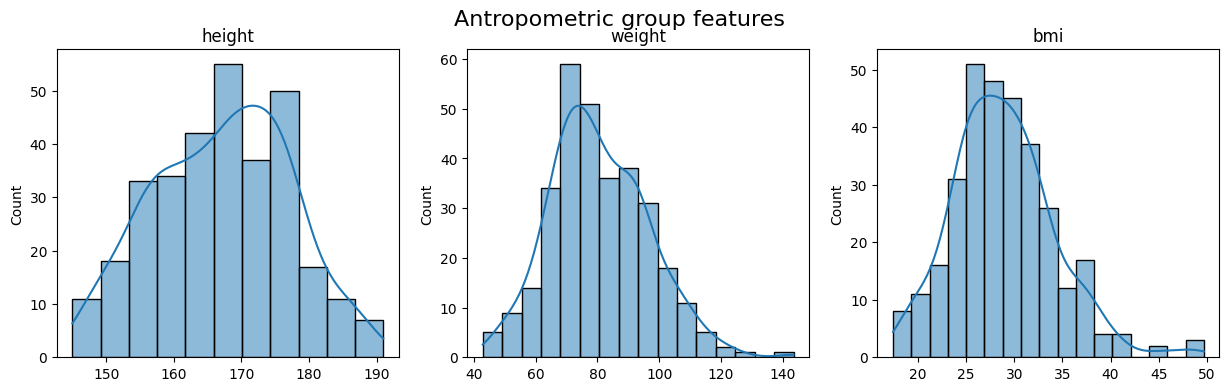

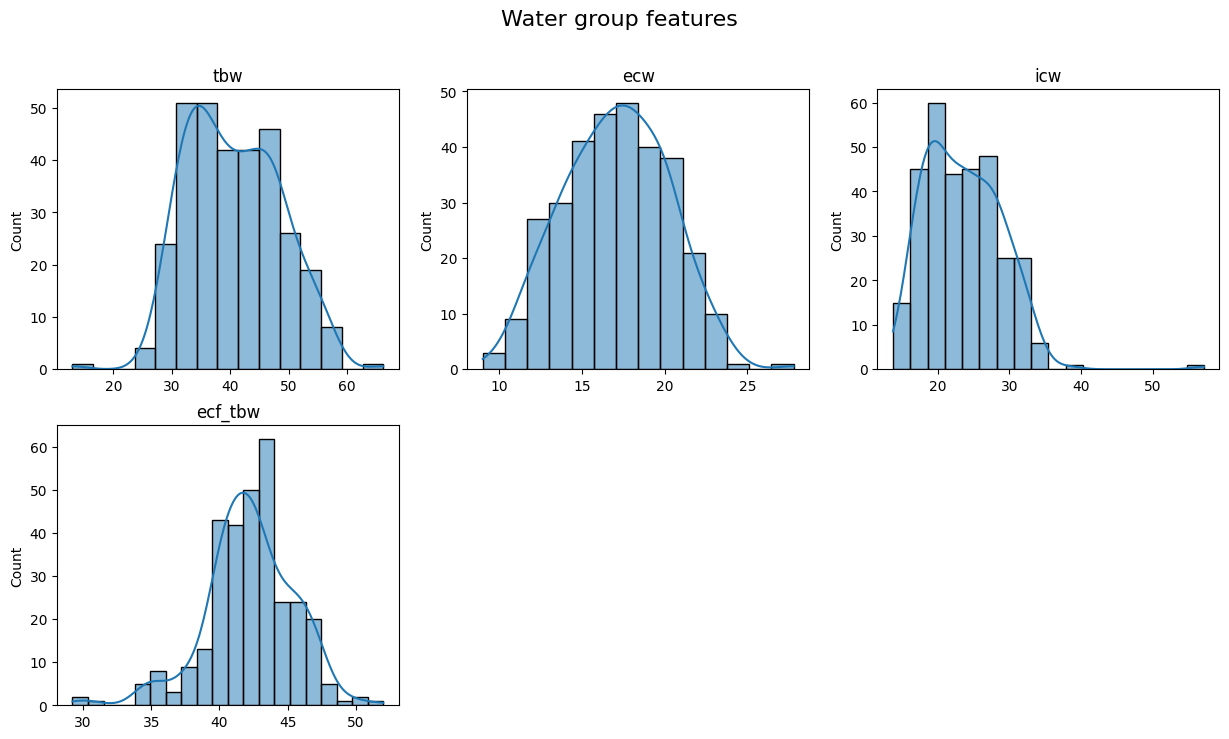

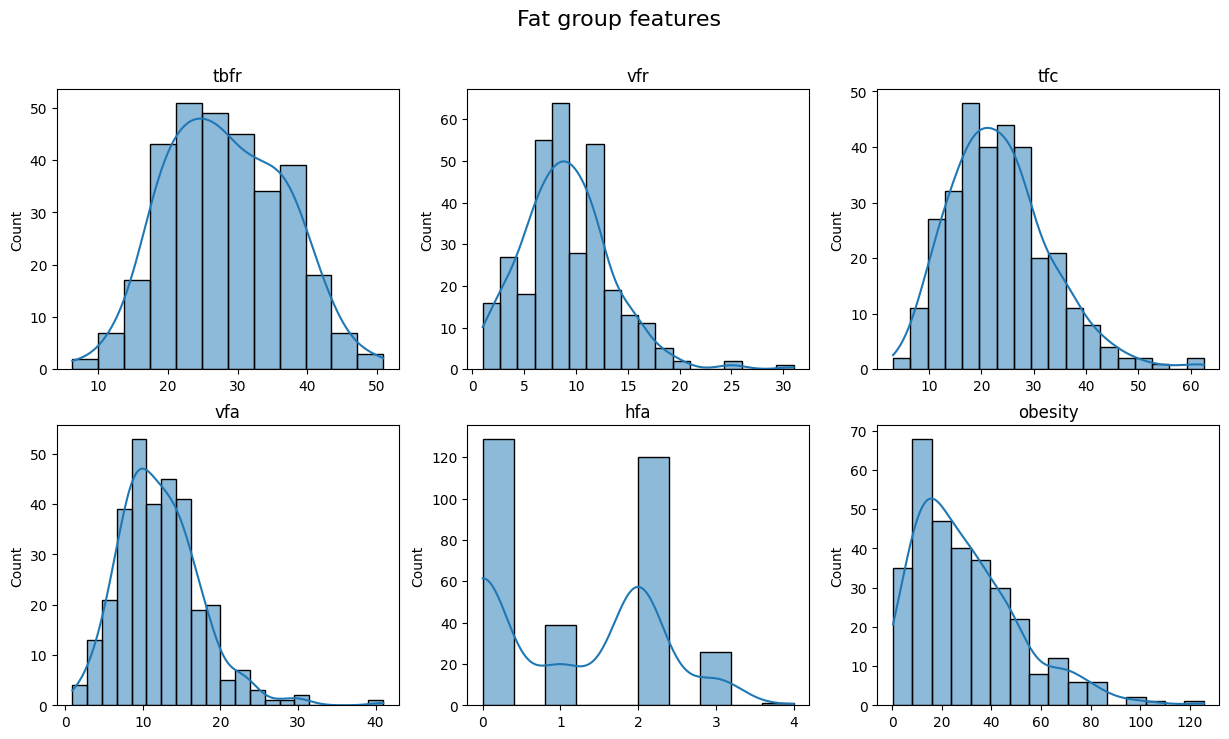

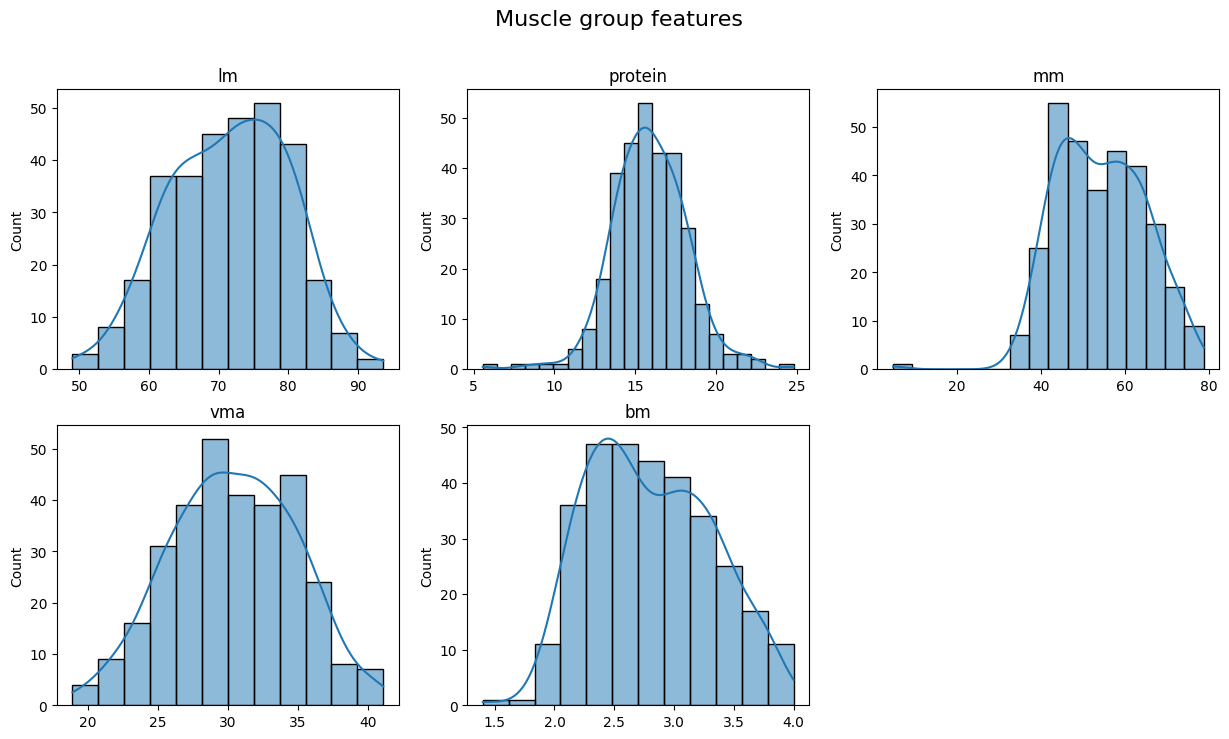

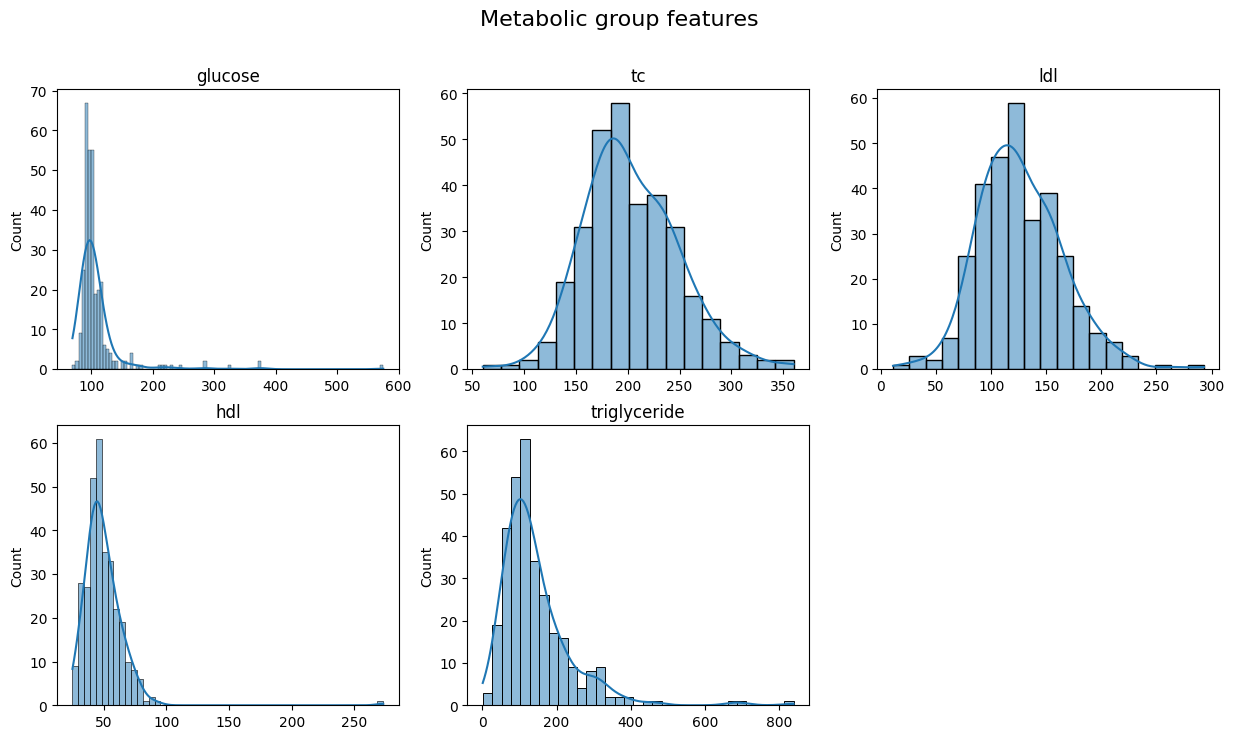

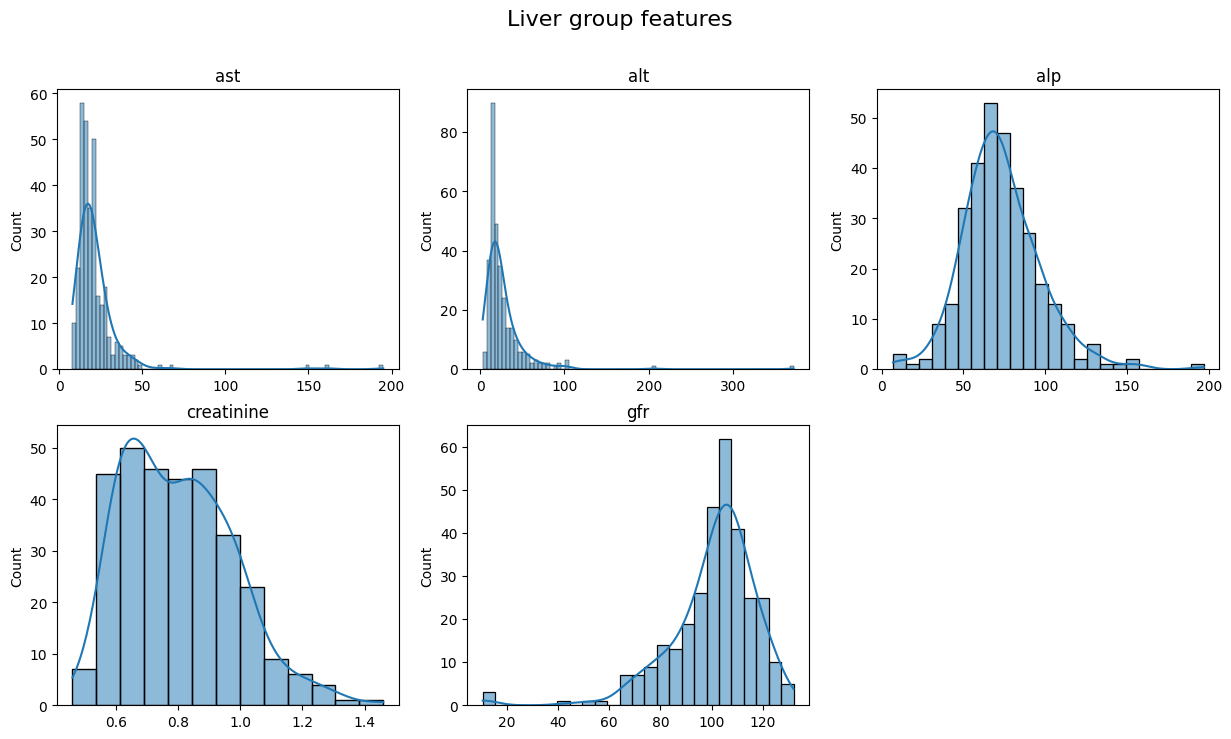

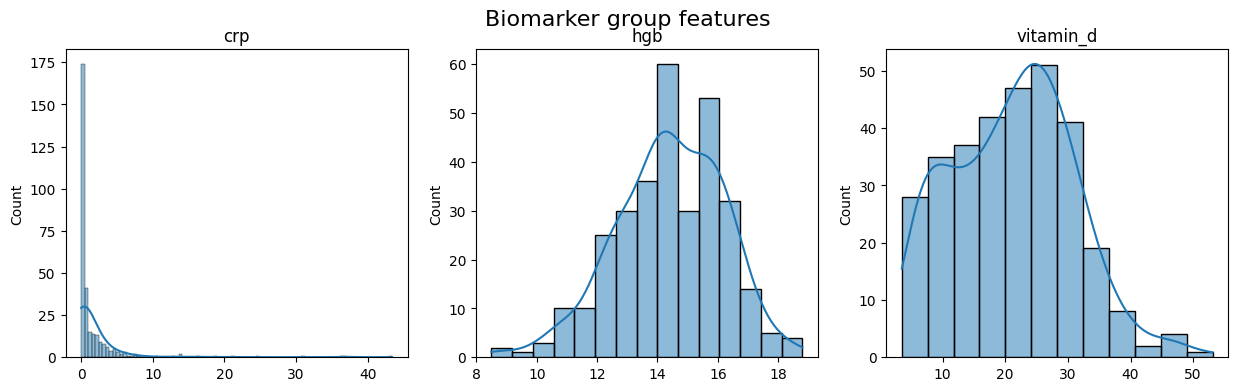

In [9]:
def plot_features(df, features, name = "", n_cols_output = 3):
    '''
    Plot list of features as histograms with overlayed kde in a grid with a provided number of columns
    '''
    n_features = len(features)

    n_cols = np.min([n_cols_output, n_features])
    n_rows = int(np.ceil(n_features / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    fig.suptitle(f"{name.capitalize()} group features", fontsize=16)

    axes = axes.flatten()
    
    for i, feature in enumerate(features):
        sns.histplot(data=df, x=feature, kde=True, ax=axes[i])
        axes[i].set_title(feature, fontsize=12)
        axes[i].set_xlabel('')

    # Remove unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.show()

df_clean = df[(df["obesity"]<1900) & (df["comorbidity"]<2)]
for group_name, features in feature_groups.items():
    plot_features(df_clean, features, name = group_name, n_cols_output=3)

### 5 Pairwise Correlations

All distributions look normal. We now plot pairwise correlations and distributions of features grouped by the gallstone status to see how balanced our sataset is.

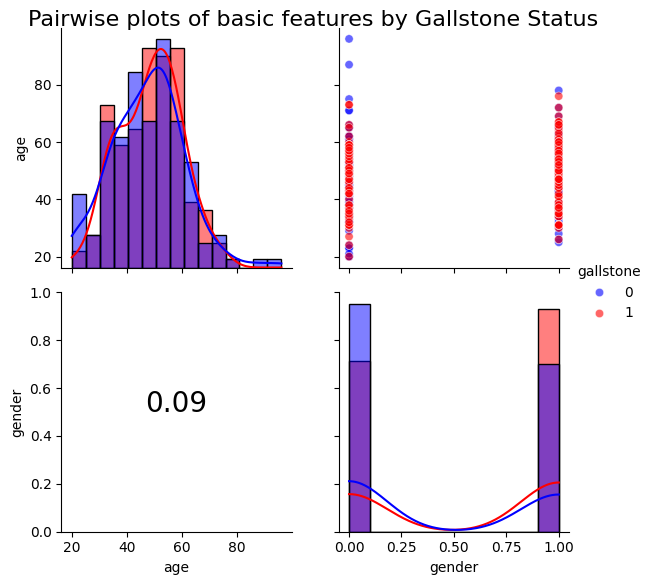

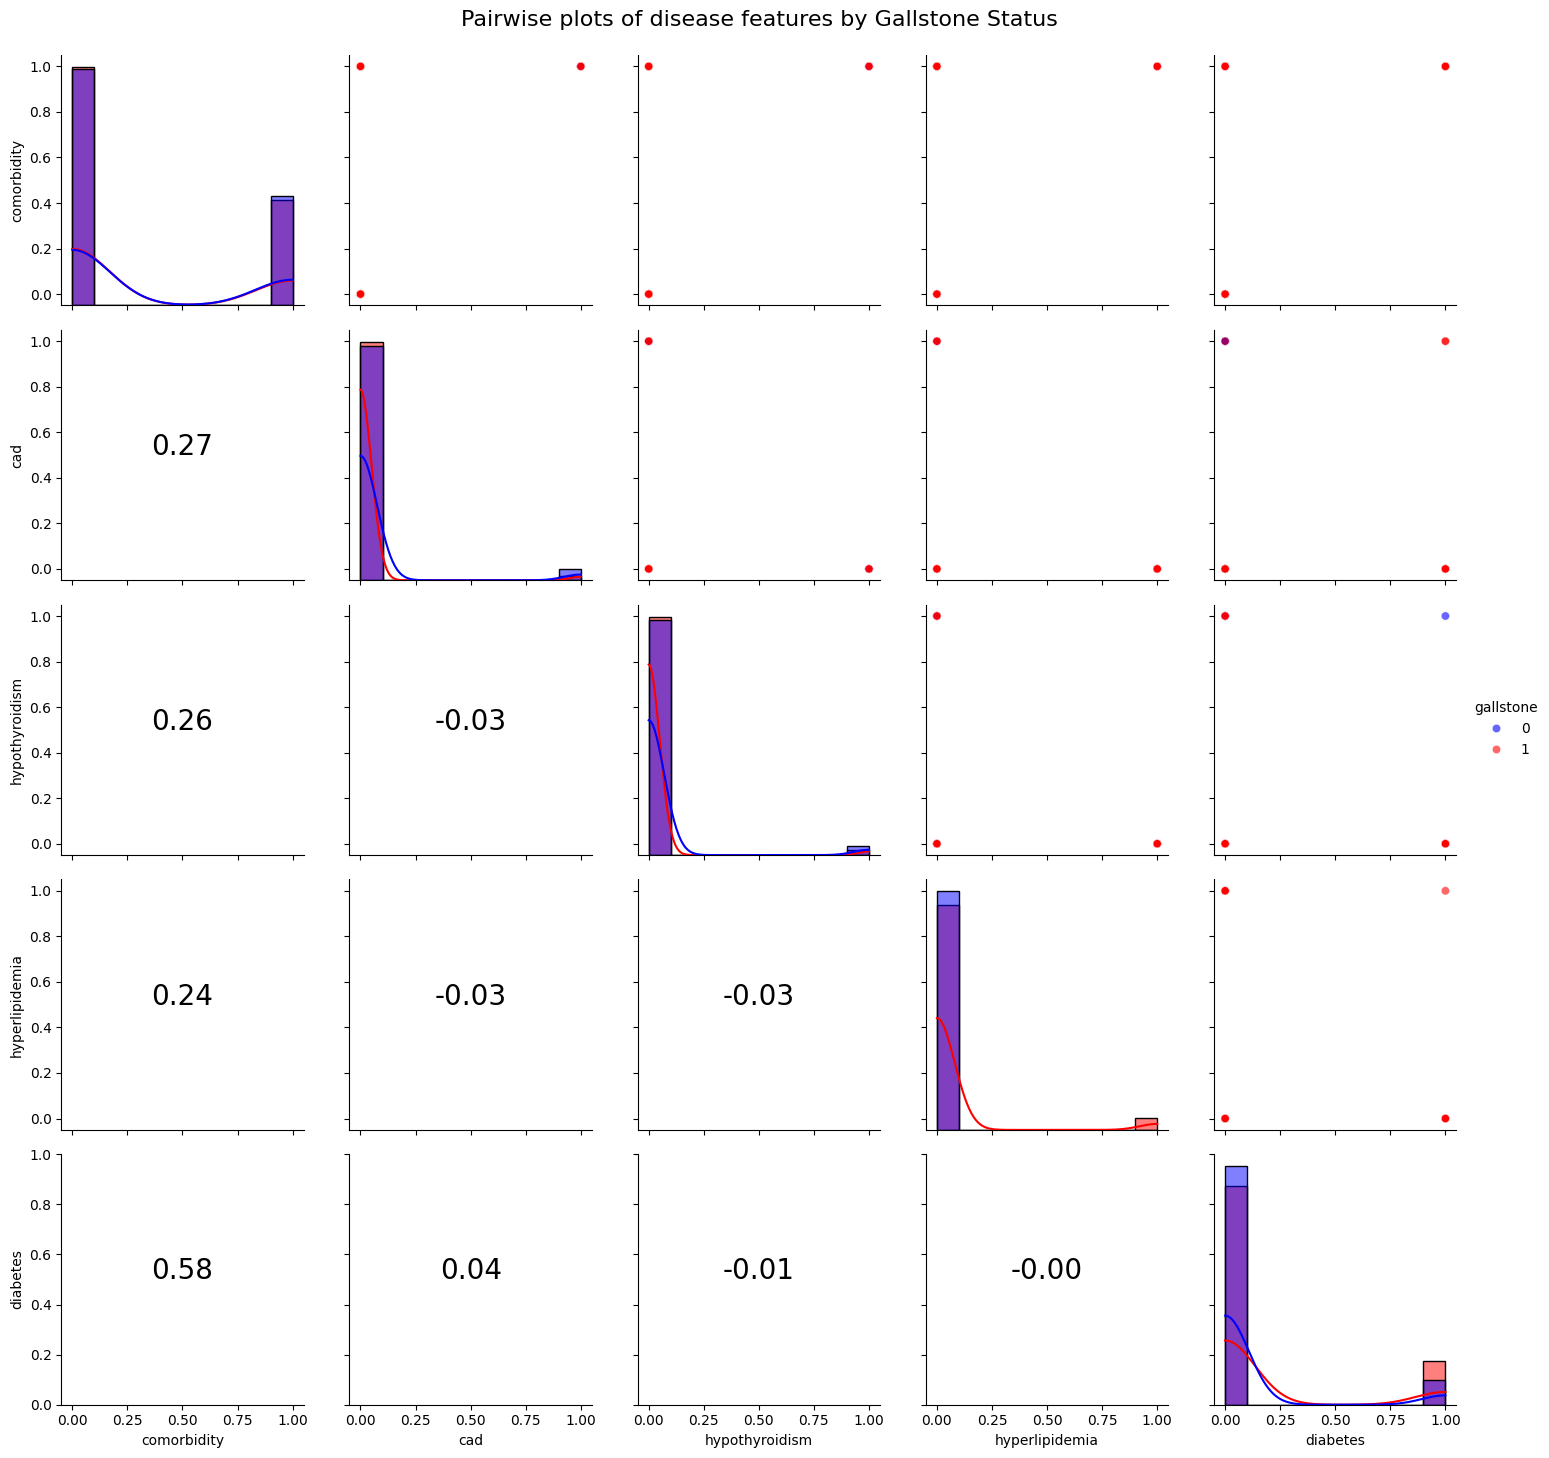

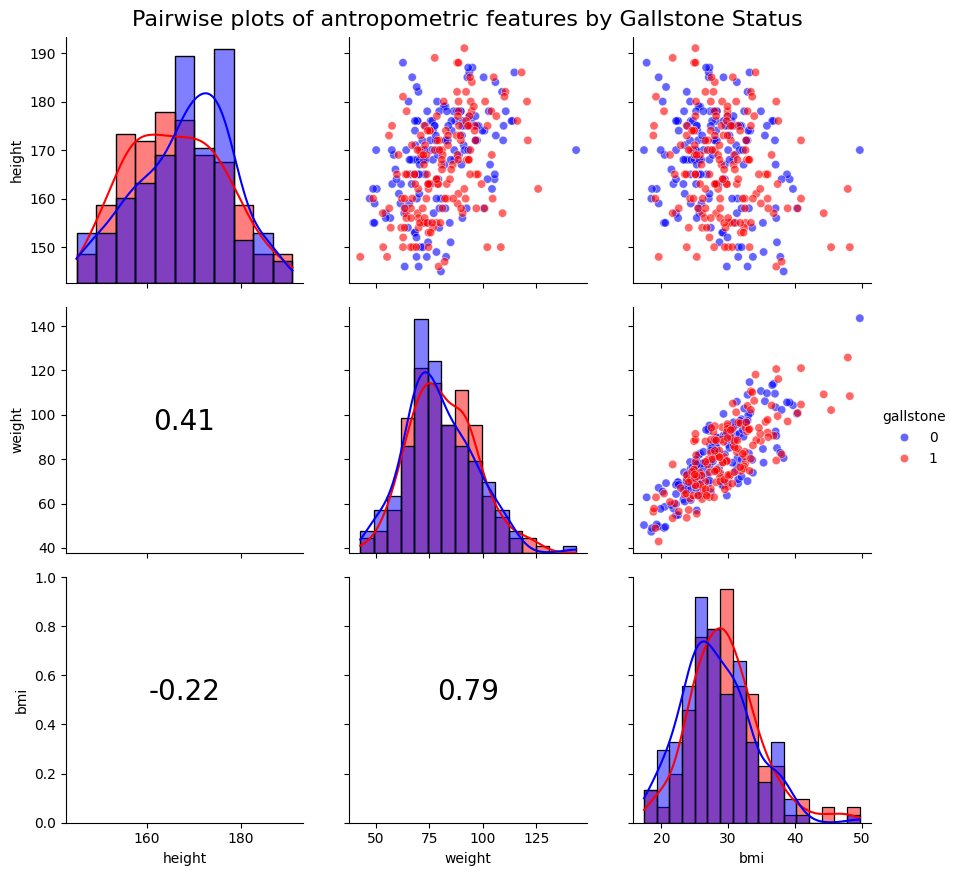

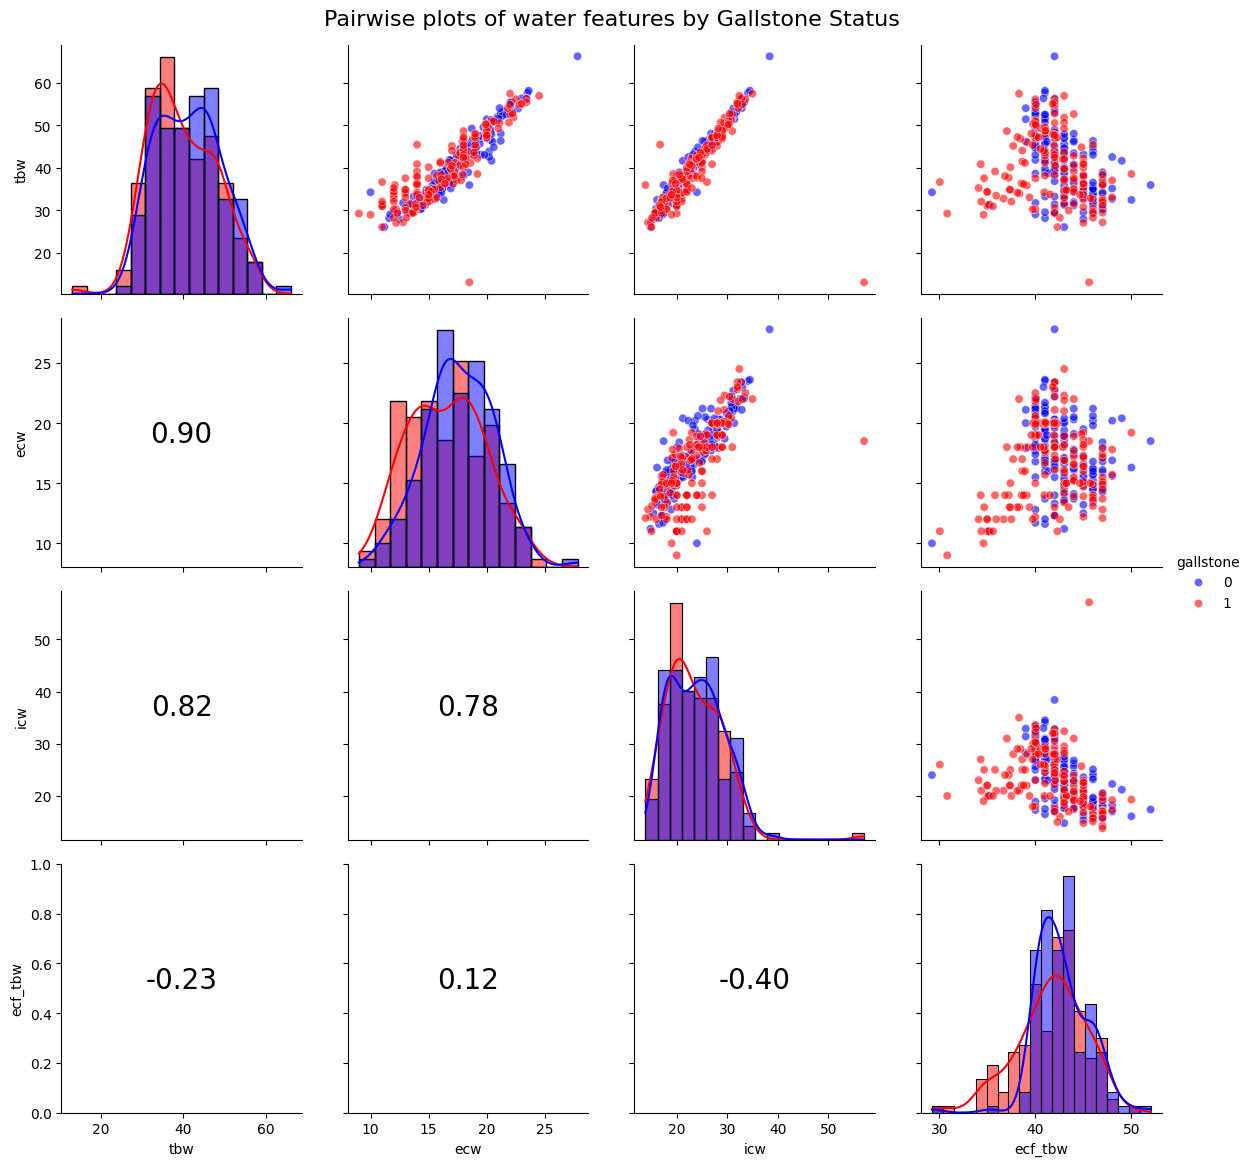

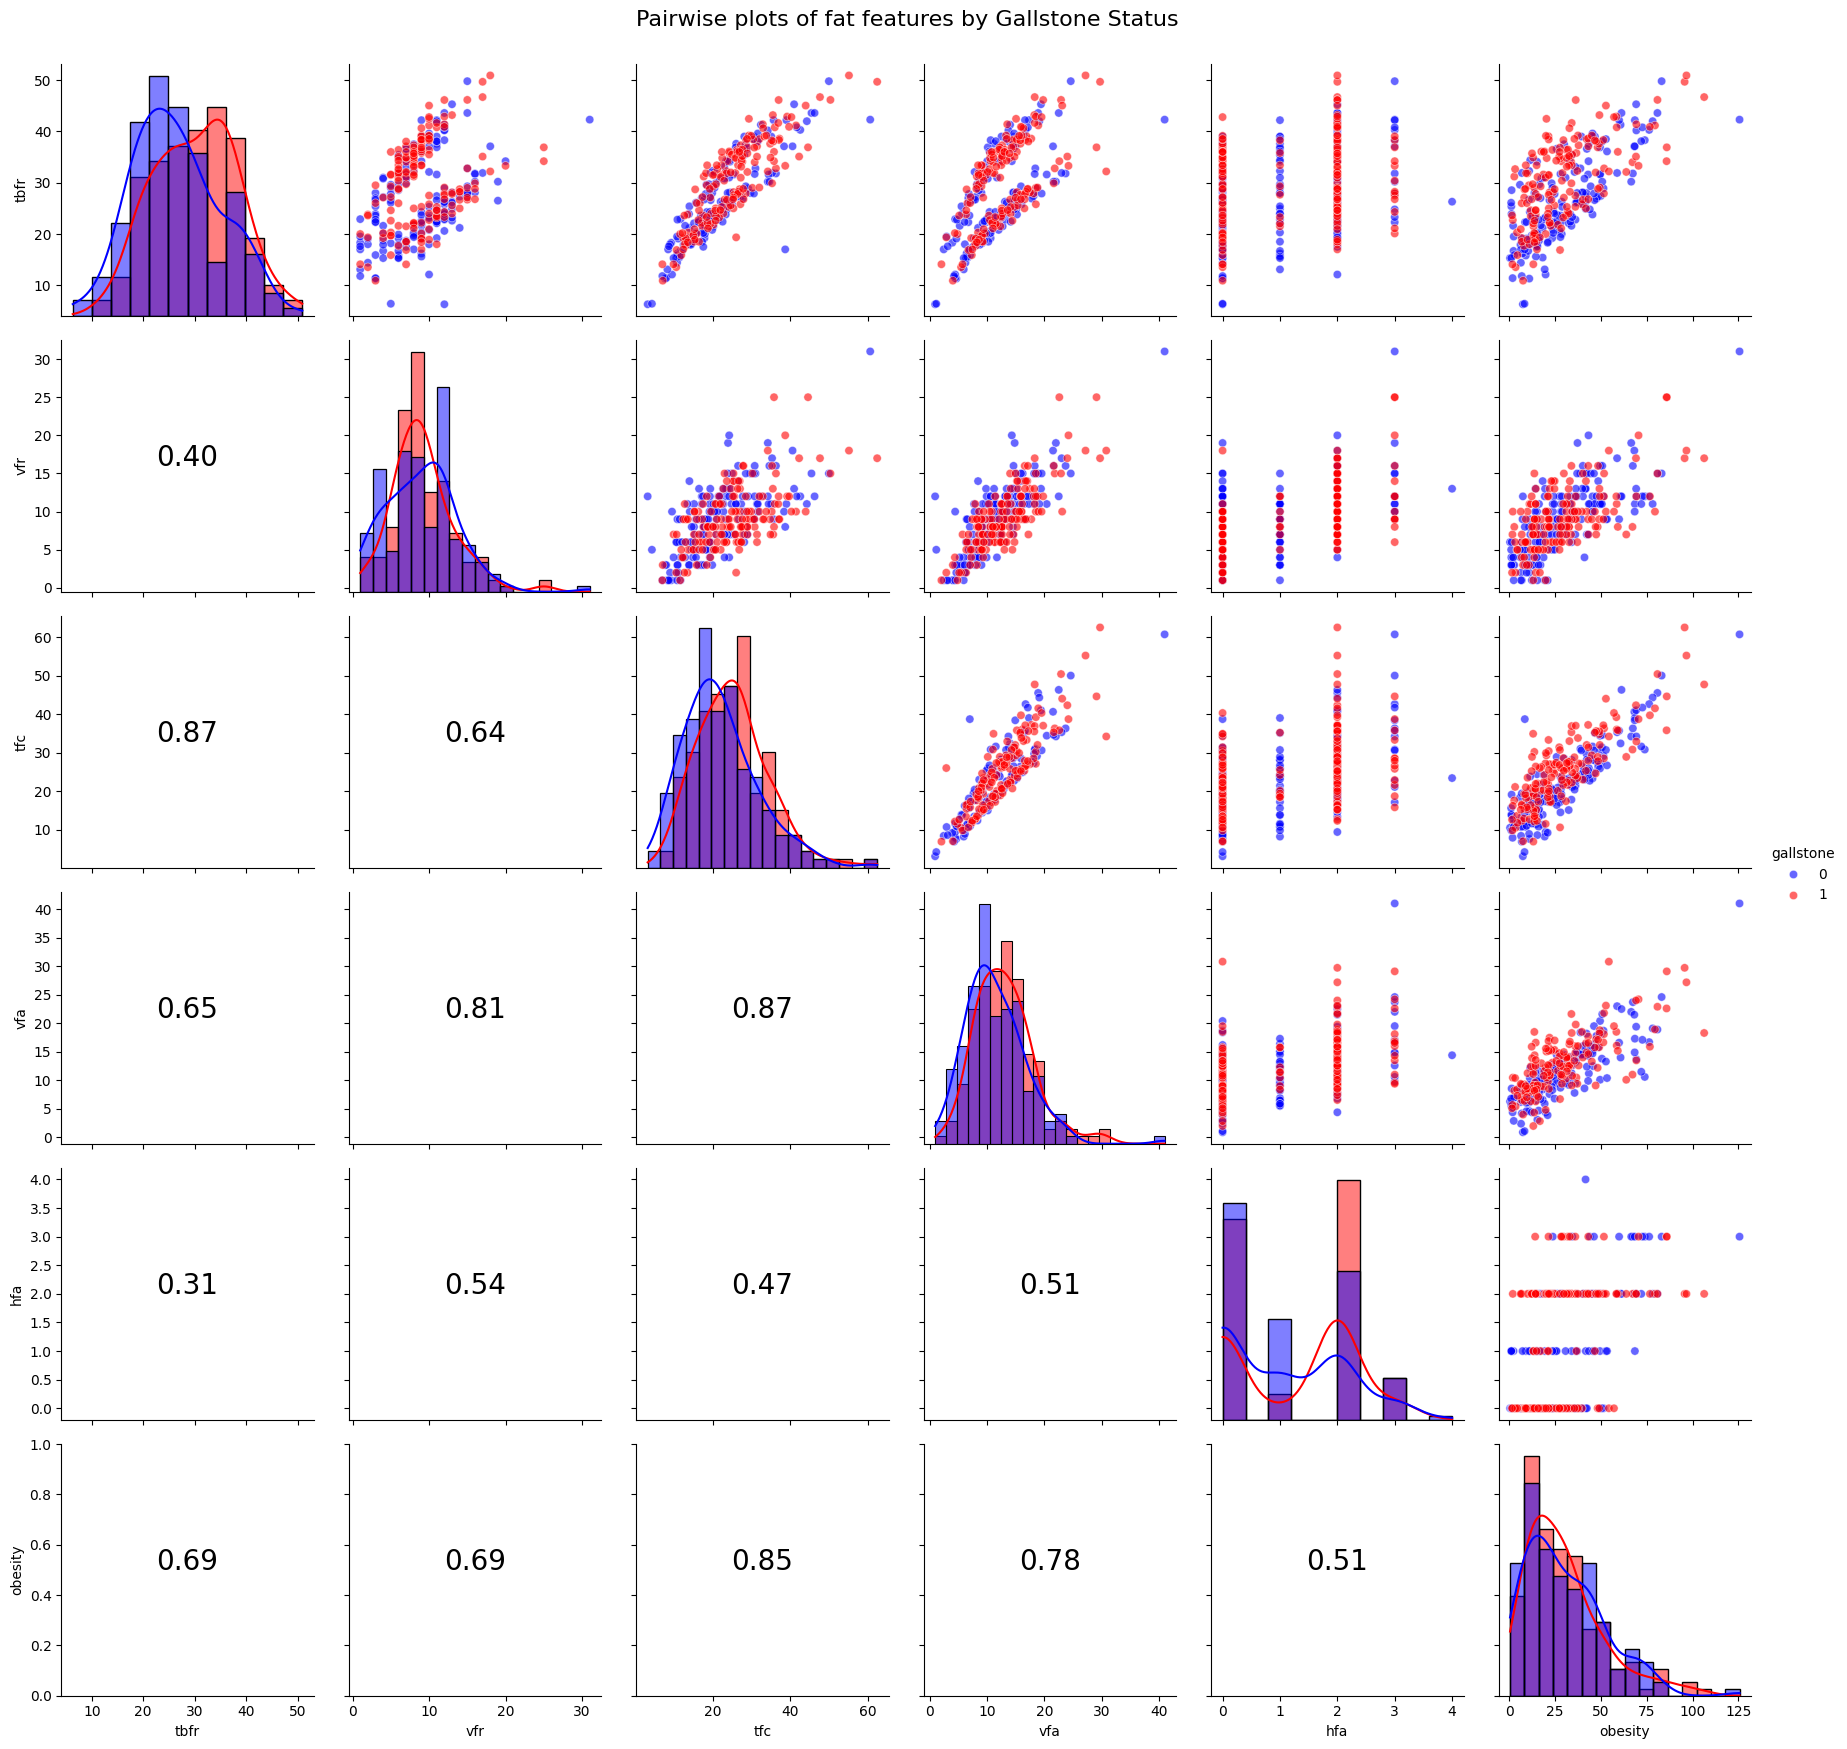

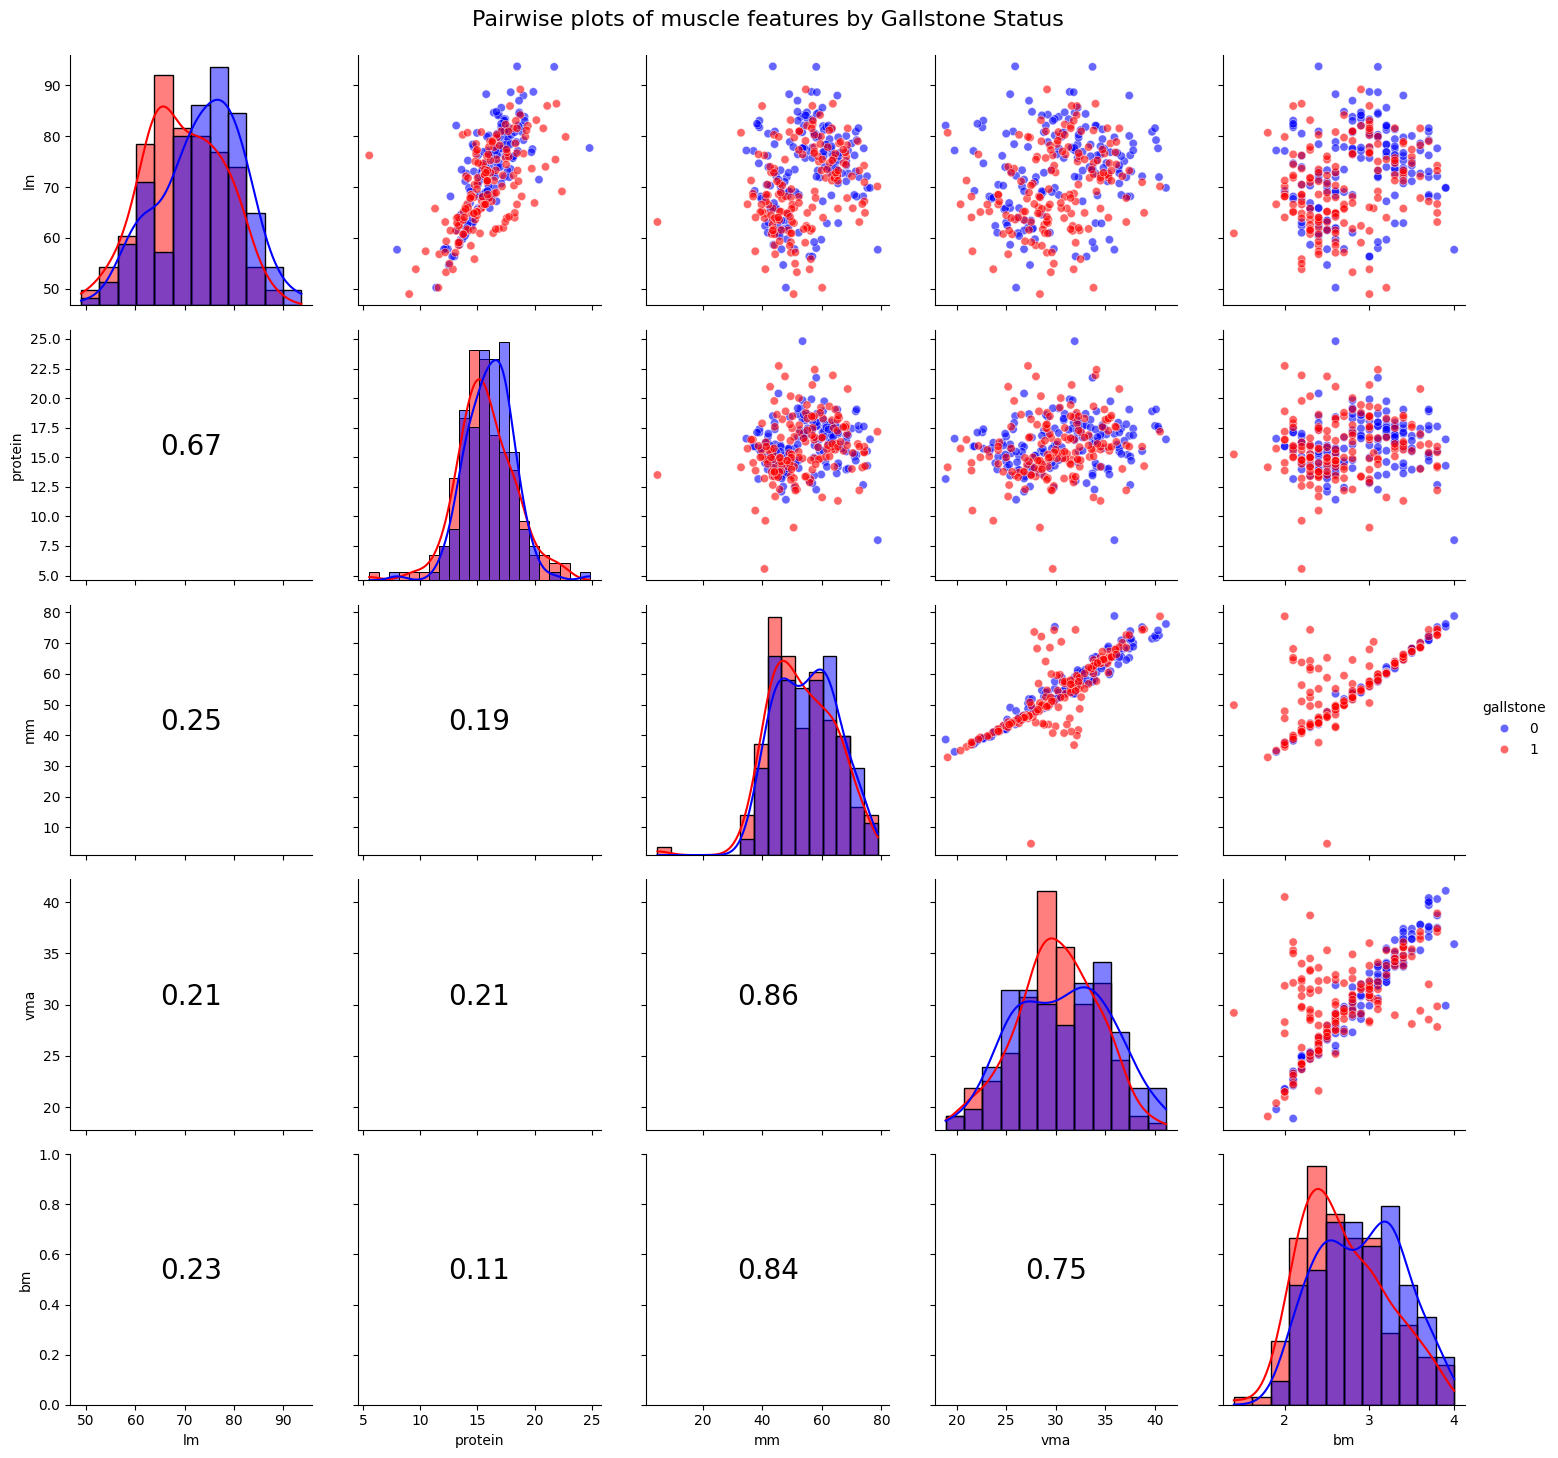

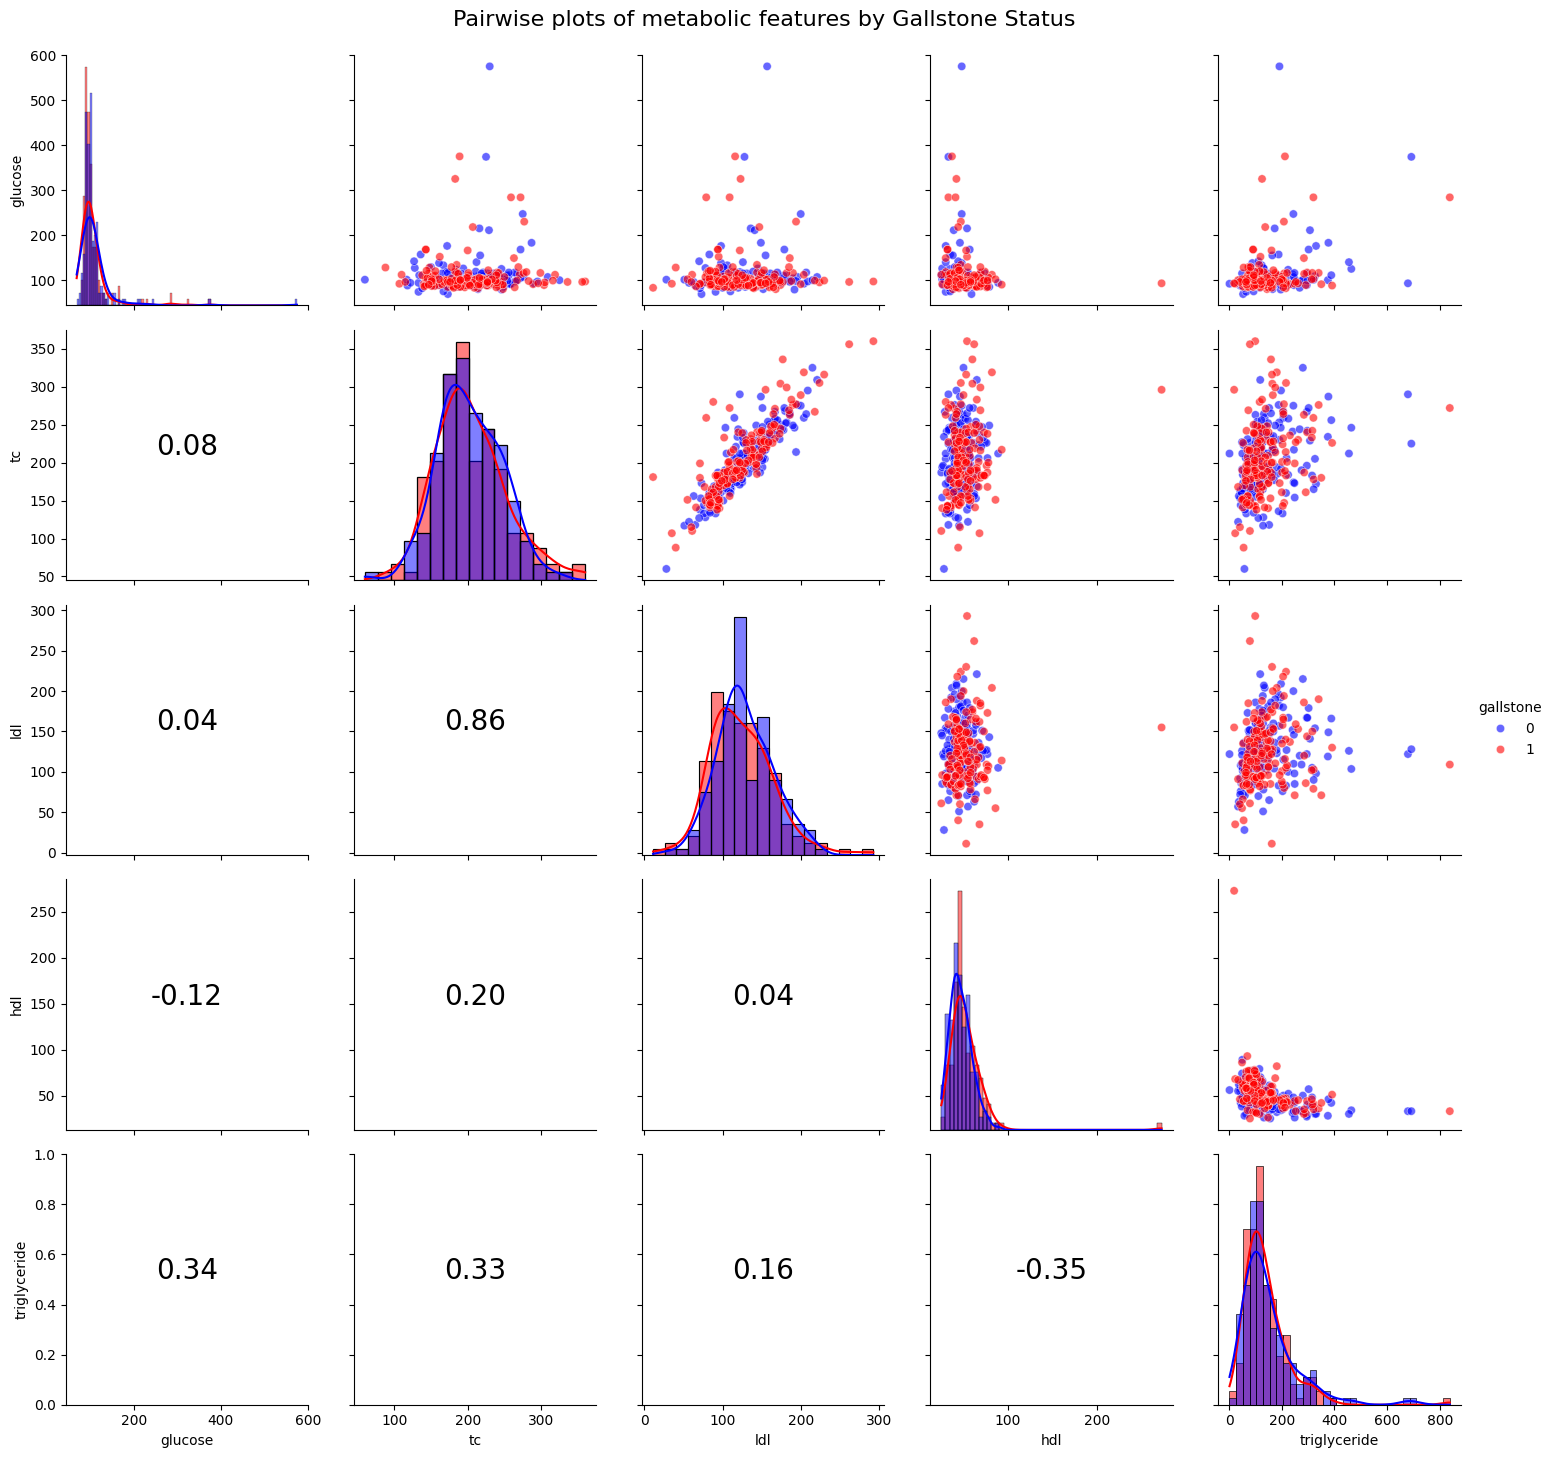

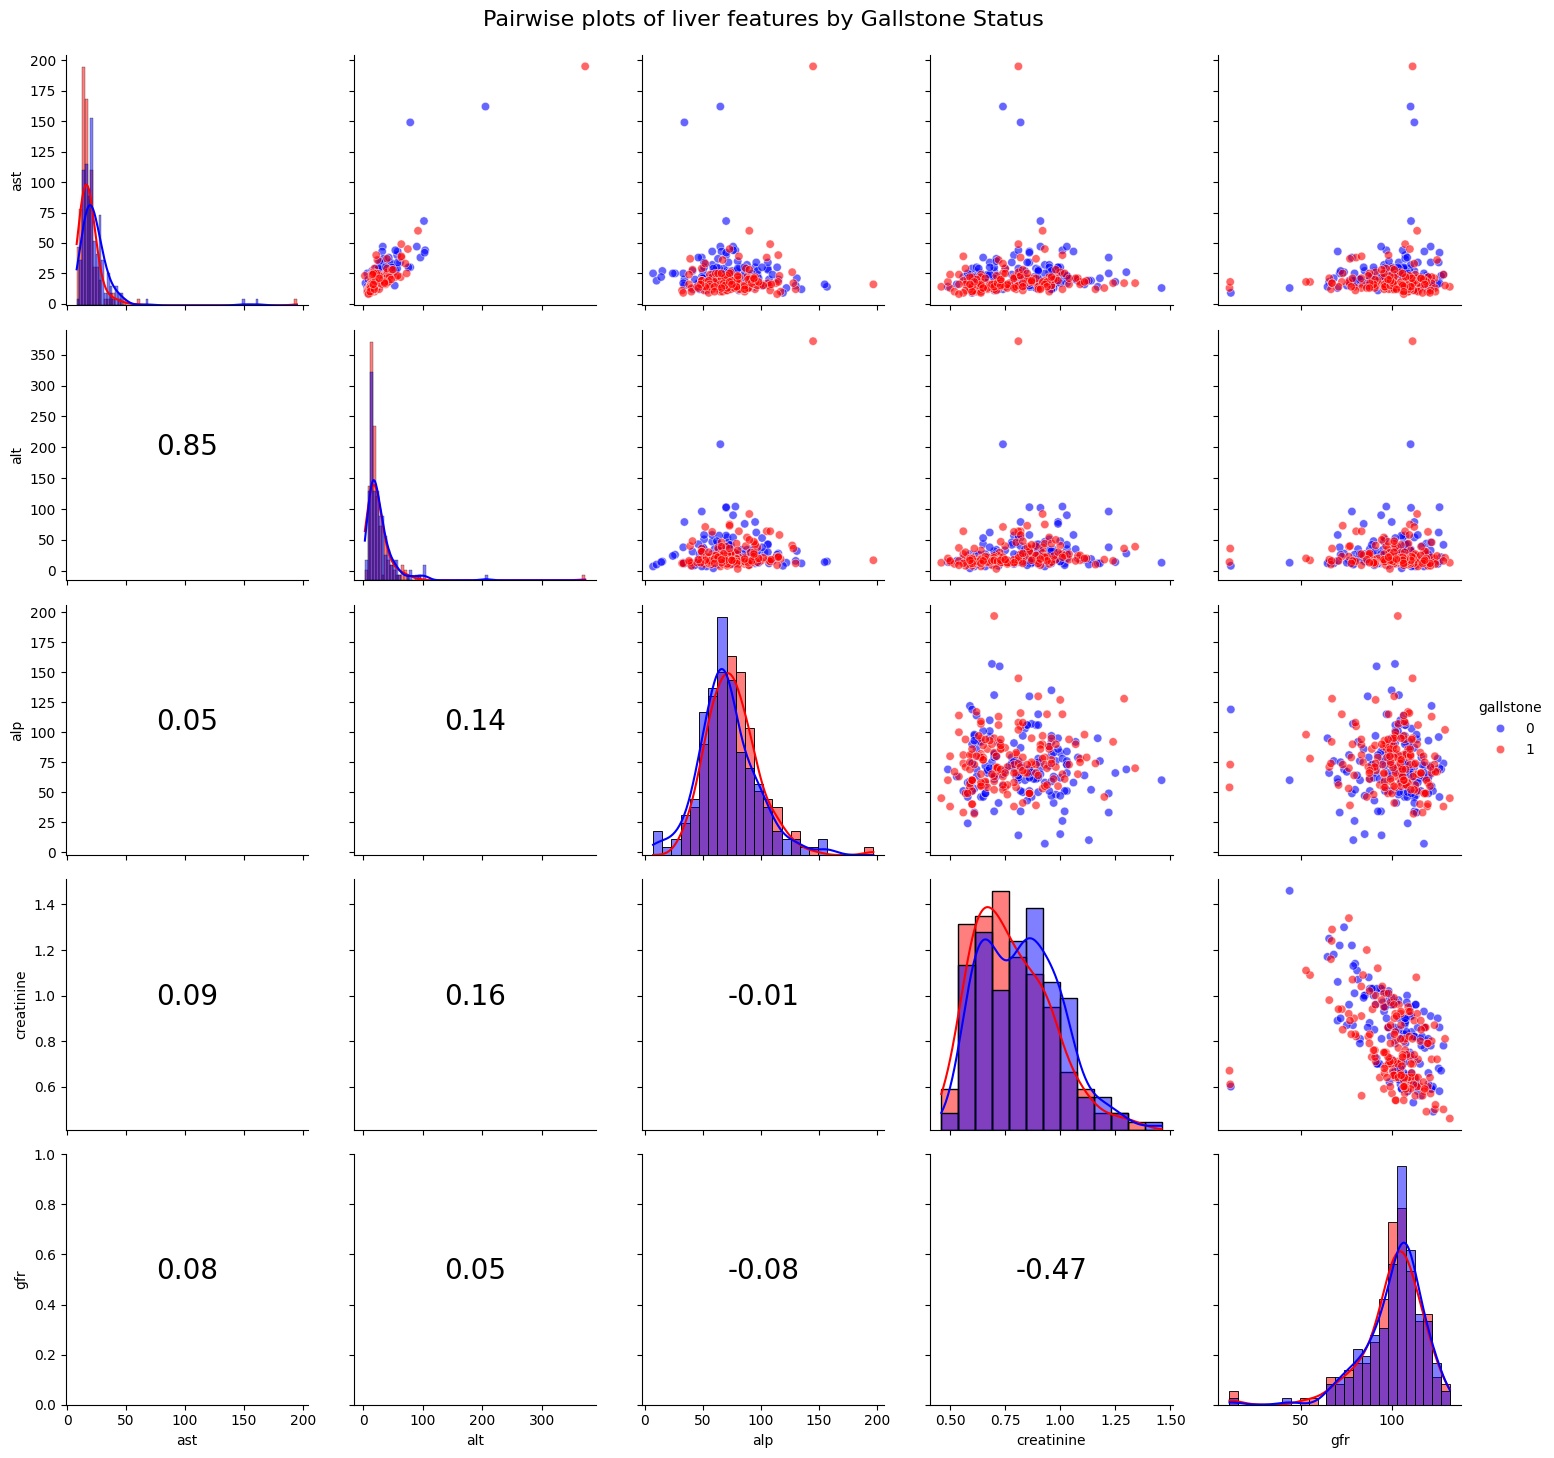

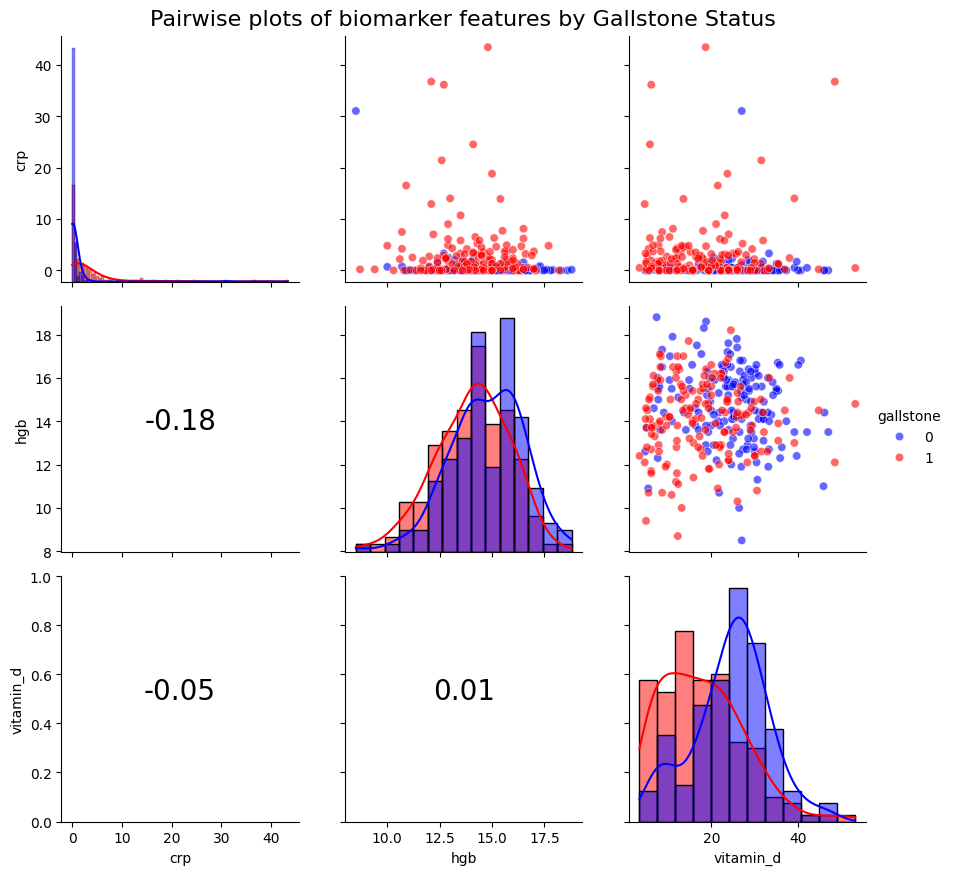

In [10]:
def show_pairplots_corr(df = df, features = numerical_cols, name = ""):
    '''
    Shows pairwise correlations for a list of features; the diagonal plots show histograms grouped and coloured by gallstone status, 
    the upper plots are scatter and the lower triangle contains pearson correlation coefficient for non-grouped feature values. 
    '''
    
    g = sns.PairGrid(df[features + ['gallstone']], hue="gallstone", palette={0:"blue", 1:"red"}, diag_sharey = False)
    g.fig.set_size_inches(3*len(features), 3*len(features))
    
    g.map_upper(sns.scatterplot, alpha=0.6)         
    g.map_diag(sns.histplot, kde=True)             

    
    for i, row_var in enumerate(features):
        for j, col_var in enumerate(features):
            if i > j:
                corr = df[row_var].corr(df[col_var])
                g.axes[i, j].annotate(f"{corr:.2f}", xy=(0.5, 0.5), xycoords='axes fraction',
                                    ha='center', fontsize=20, color='black')

    g.fig.suptitle(f"Pairwise plots of {name} features by Gallstone Status", fontsize=16)
    plt.subplots_adjust(top=0.95)
    g.add_legend()

    plt.show()

for group_name, features in feature_groups.items():
    show_pairplots_corr(df_clean, features=features, name = group_name)

Key insights:  
- **Anthropometric features** (height, weight, BMI) show differences that can be partly explained by gender imbalance.  
- **Disease features** such as diabetes and hypothyroidism are more prevalent among gallstone patients.  
- **Biomarkers** like Vitamin D and CRP show notable differences between groups.  

This visualization step not only confirms earlier statistical summaries but also highlights where gallstone-positive and -negative groups diverge.  

Further findings:  
- The dataset is generally well-balanced, with both groups well represented across most features.  
- Some groups (especially anthropometric and fat-related features) show **collinearities** — for example, BMI is strongly related to body fat percentage and visceral fat area.  
- These collinearities are expected in biological datasets and must be considered in modeling to avoid instability (e.g.by an appropriate regularization).  

### 6. Correlation Heatmap

We continue exploring data with with a correlation heatmap.

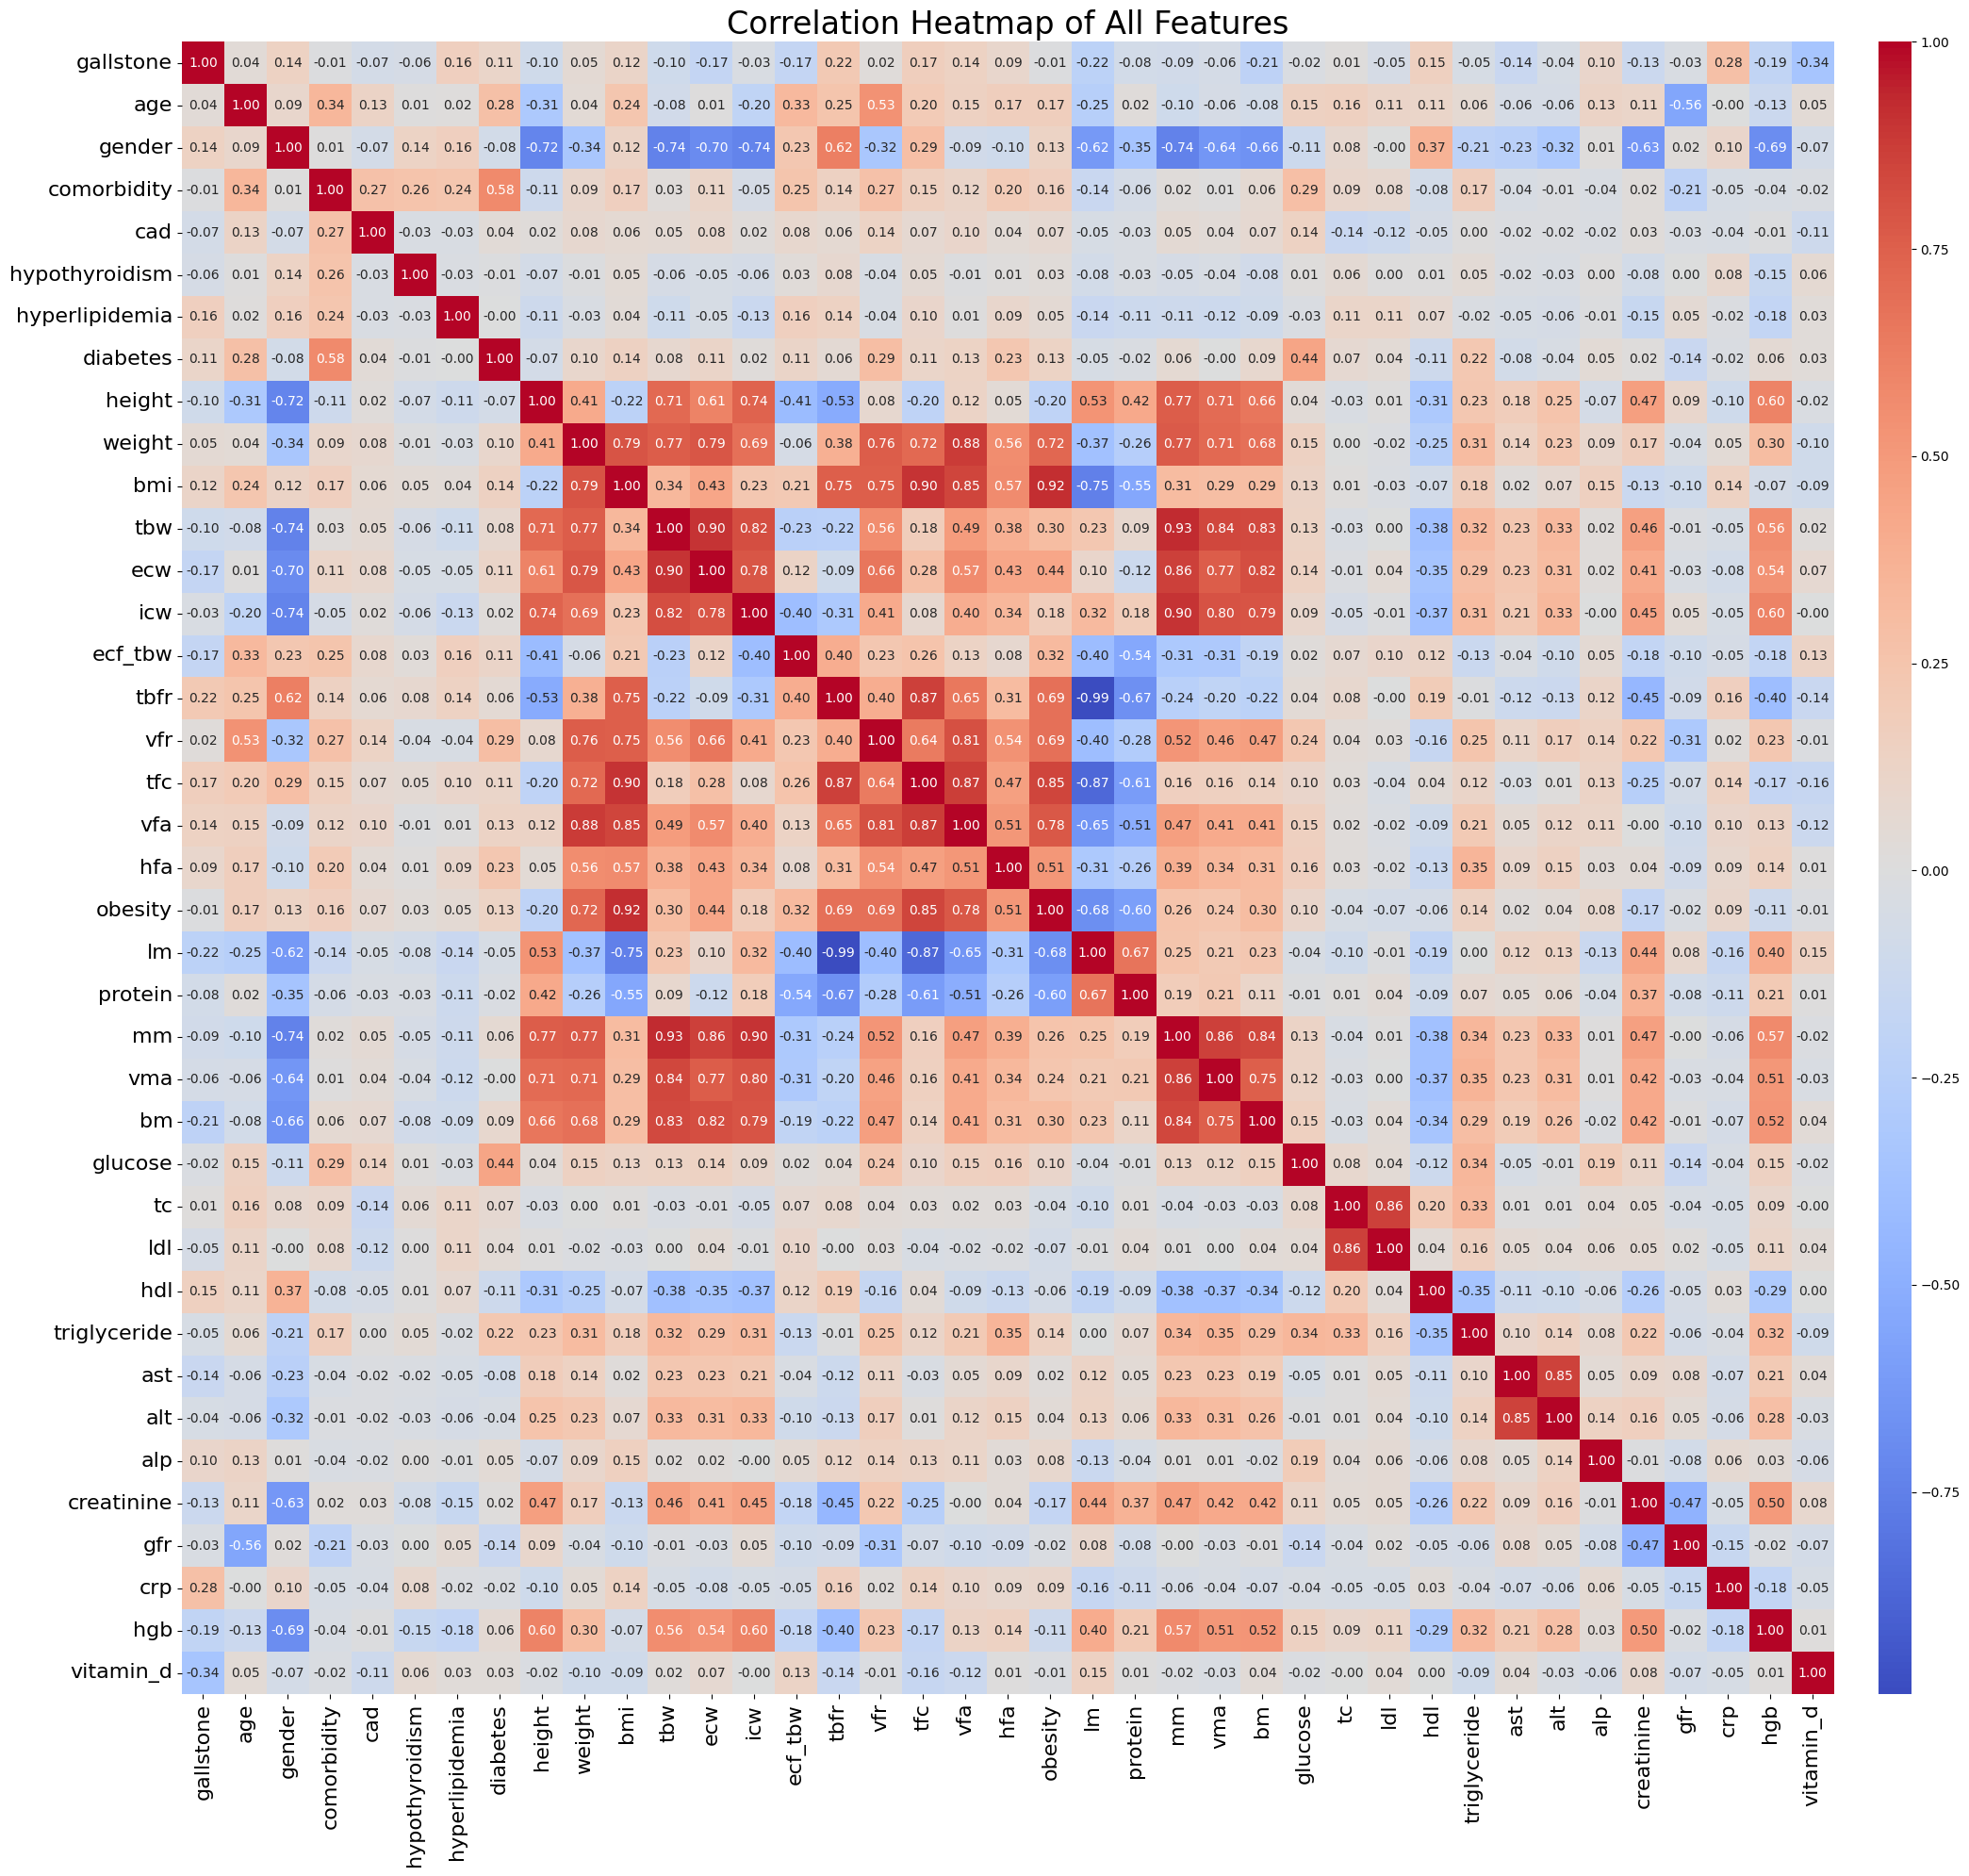

In [11]:
plt.figure(figsize=(25, 20))

columns_order = ["gallstone"] + [feature for group in feature_groups.values() for feature in group]

sns.heatmap(
    df_clean[columns_order].corr(),
    annot=True,        
    fmt=".2f",         
    cmap="coolwarm",   
    center=0,          
    square=True,       
    cbar_kws={"aspect": 50, "pad": 0.02}  
)
plt.xticks(fontsize=16)  
plt.yticks(fontsize=16)
plt.title("Correlation Heatmap of All Features", fontsize=24)
plt.tight_layout()
plt.show()

A global heatmap of all features highlights:  
- **Strong correlations** within groups (e.g., fat-related measures are highly correlated with each other).   
- Multiple clusters of interdependent features, suggesting dimensionality reduction (e.g., PCA) or regularization techniques may be useful.  

This step reassures us that the dataset is rich but redundant in some areas. 

### 7 Feature Importance with Gallstone Status

At last, we inspected the direct relationship between each feature and gallstone status using two complementary methods:  

1. **Pearson correlation** (linear dependence).  
2. **ANOVA F-score and p-value** (statistical significance of association). 

In principle, this step should be performed on train data only to prevent the data leakage. Since we are not going to use the results to construct a model, we use the full dataset here.

In [12]:
from sklearn.feature_selection import f_classif

gallstone_corr = df_clean.corr()[["gallstone"]]
gallstone_corr = gallstone_corr.drop(gallstone_corr.index[0])

F, p = f_classif(df_clean.drop(columns=["gallstone"]), df_clean['gallstone'])

gallstone_corr["F-score"] = F
gallstone_corr["p-value"] = p

gallstone_corr = gallstone_corr.sort_values(by="F-score", key=abs, ascending=False).reset_index()
gallstone_corr.index = gallstone_corr.index + 1   
gallstone_corr = gallstone_corr.rename(columns={"index": "Feature","gallstone": "Pearson correlation"})

gallstone_corr.head(20).style.format({
    "Pearson correlation": "{:.2f}",
    "F-score": "{:.2f}",
    "p-value": "{:.4f}"
    }).set_caption("Feature Importance: Correlation, F-score and p-value")


The analysis identified the following **top features**:  
- Vitamin D (lower in gallstone patients).  
- C-Reactive Protein (higher in gallstone patients).  
- Lean mass.  
- Total body fat ratio.  
- Bone mass.  

These features stand out as promising predictors for modeling, though many others may still contribute indirectly through interaction effects.  

### 8 Conclusion

- The dataset is **clean, structured, and rich in clinical/biological information**.  
- **4 outliers** were detected (1 extreme obesity value and 3 comorbidity misentries).  
- **Gender imbalance** (among gallstone positive **57% are females** and **43% are males**) exists in gallstone prevalence.  
- Many features are **collinear**, so models must be chosen with regularization or feature-selection strategies.  
- **Top predictive features** are Vitamin D, CRP, lean mass, fat ratio, and bone mass — consistent with medical intuition learnt from the literature.  

This exploratory analysis sets the stage for building predictive models with ElasticNet and TensorFlow. 